In [1]:
import numpy as np
import shutil
import os
import tensorflow as tf
print(tf.__version__)

1.15.0


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("mnist/data", one_hot = True, reshape = False)
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
(55000, 28, 28, 1)
(55000, 10)


In [3]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

# Exploring the data

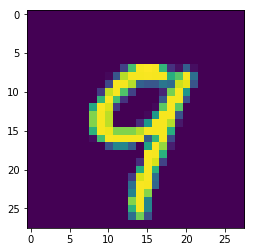

In [4]:
import matplotlib.pyplot as plt
IMGNO = 12
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

# Define the model.

### Build Keras Model Using Keras Sequential API

In [5]:
def linear_model(hparams):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = [HEIGHT, WIDTH, 1], name = "image"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = NCLASSES, activation = tf.nn.softmax, name = "probabilities"))
    return model

In [6]:
def dnn_model(hparams):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = [HEIGHT, WIDTH, 1], name = "image"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = 300, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dense(units = 100, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dense(units = 30, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dense(units = NCLASSES, activation = tf.nn.softmax, name = "probabilities"))
    return model

In [7]:
def dnn_dropout_model(hparams):
    dprob = hparams.get("dprob", 0.1)
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = [HEIGHT, WIDTH, 1], name = "image"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = 300, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dense(units = 100, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dense(units = 30, activation = tf.nn.relu))
    model.add(tf.keras.layers.Dropout(rate = dprob))
    model.add(tf.keras.layers.Dense(units = NCLASSES, activation = tf.nn.softmax, name = "probabilities"))
    return model

In [14]:
def cnn_model(hparams):
    ksize1 = hparams.get("ksize1", 5)
    ksize2 = hparams.get("ksize2", 5)
    nfil1 = hparams.get("nfil1", 10)
    nfil2 = hparams.get("nfil2", 20)
    dprob = hparams.get("dprob", 0.25)
    print('>>>>>>>',ksize1, type(ksize1))
    print('>>>>>>>',ksize1, type(ksize1))
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = [HEIGHT, WIDTH, 1], name = "image")) # shape = (?, 28, 28, 1)
    model.add(tf.keras.layers.Conv2D(filters = nfil1, kernel_size = ksize1, padding = "same", activation = tf.nn.relu)) # shape = (?, 28, 28, nfil1)
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2)) # shape = (?, 14, 14, nfil1)
    model.add(tf.keras.layers.Conv2D(filters = nfil2, kernel_size = ksize2, padding = "same", activation = tf.nn.relu)) # shape = (?, 14, 14, nfil2)
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2)) # shape = (?, 7, 7, nfil2)
    model.add(tf.keras.layers.Flatten())

    # Apply batch normalization
    if hparams["batch_norm"]:
        model.add(tf.keras.layers.Dense(units = 300, activation = tf.nn.relu))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation = tf.nn.relu))
    else:  
        model.add(tf.keras.layers.Dense(units = 300, activation = tf.nn.relu))
  
    # Apply dropout
    model.add(tf.keras.layers.Dropout(rate = dprob))

    model.add(tf.keras.layers.Dense(units = NCLASSES, activation = None))
  
    # Apply batch normalization once more
    if hparams["batch_norm"]:
        model.add(tf.keras.layers.BatchNormalization())
        
    model.add(tf.keras.layers.Dense(units = NCLASSES, activation = tf.nn.softmax, name = "probabilities"))
    return model


# Write Input Functions

In [9]:
def serving_input_fn():
    # Input will be rank 3
    feature_placeholders = {
        "image": tf.placeholder(dtype = tf.float32, shape = [None, HEIGHT, WIDTH])}
    # But model function requires rank 4
    features = {
        "image": tf.expand_dims(input = feature_placeholders["image"], axis = -1)} 
    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = feature_placeholders)

# Write Custom Estimator

In [10]:
def image_classifier(hparams):
    model_functions = {
        'linear': linear_model,
        'dnn': dnn_model,
        'dnn_dropout': dnn_dropout_model,
        'cnn': cnn_model}
    
    # Get function pointer for selected model type
    model_function = model_functions[hparams['model']]
    
    # Build selected Keras model
    model = model_function(hparams)
    
    return model

In [11]:
def train_and_evaluate(output_dir, hparams):
    tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
    EVAL_INTERVAL = 60

    # Get mnist data
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Scale our features between 0 and 1
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    # Reshape images to add a dimension for channels (1 in this case)
    x_train = x_train.reshape([-1, HEIGHT, WIDTH, 1])
    x_test = x_test.reshape([-1, HEIGHT, WIDTH, 1])

    # Convert labels to categorical one-hot encoding
    y_train = tf.keras.utils.to_categorical(y = y_train, num_classes = NCLASSES)
    y_test = tf.keras.utils.to_categorical(y = y_test, num_classes = NCLASSES)

    # Create training input function
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {"image": x_train},
        y = y_train,
        batch_size = 100,
        num_epochs = None,
        shuffle = True,
        queue_capacity = 5000
      )

    # Create evaluation input function
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {"image": x_test},
        y = y_test,
        batch_size = 100,
        num_epochs = 1,
        shuffle = False,
        queue_capacity = 5000
      )
    
    # Build Keras model
    model = image_classifier(hparams)
        
    # Compile Keras model with optimizer, loss function, and eval metrics
    model.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"])
        
    # Convert Keras model to an Estimator
    estimator = tf.keras.estimator.model_to_estimator(
        keras_model = model, 
        model_dir = output_dir, 
        config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL))

    # Set estimator's train_spec to use train_input_fn and train for so many steps
    train_spec = tf.estimator.TrainSpec(
        input_fn = train_input_fn,
        max_steps = hparams["train_steps"])

    # Create exporter that uses serving_input_fn to create saved_model for serving
    exporter = tf.estimator.LatestExporter(
        name = "exporter", 
        serving_input_receiver_fn = serving_input_fn)

    # Set estimator's eval_spec to use eval_input_fn and export saved_model
    eval_spec = tf.estimator.EvalSpec(
        input_fn = eval_input_fn,
        steps = None,
        exporters = exporter,
        throttle_secs = EVAL_INTERVAL)

    # Run train_and_evaluate loop
    tf.estimator.train_and_evaluate(
        estimator = estimator, 
        train_spec = train_spec, 
        eval_spec = eval_spec)

# 모델별로 실행(linear / dnn / dnn_dropout / cnn)

In [ ]:
hparams = {"model": "linear",            
           "ksize1": 5,               "nfil1": 10,
           "ksize2": 5,               "nfil2": 20,
           "batch_norm": False,       "dprob": 0.25,
           "train_steps": 1000,       "learning_rate": 0.01,
          }
OUTDIR = "mnist/learned_"+hparams["model"]
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time
print('>>>>',OUTDIR)
train_and_evaluate(OUTDIR, hparams)

In [ ]:
hparams = {"model": "dnn",            
           "ksize1": 5,               "nfil1": 10,
           "ksize2": 5,               "nfil2": 20,
           "batch_norm": False,       "dprob": 0.25,
           "train_steps": 1000,       "learning_rate": 0.01,
          }
OUTDIR = "mnist/learned_"+hparams["model"]
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time

train_and_evaluate(OUTDIR, hparams)

In [ ]:
hparams = {"model": "dnn_dropout",            
           "ksize1": 5,               "nfil1": 10,
           "ksize2": 5,               "nfil2": 20,
           "batch_norm": False,       "dprob": 0.25,
           "train_steps": 1000,       "learning_rate": 0.01,
          }
OUTDIR = "mnist/learned_"+hparams["model"]
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time

train_and_evaluate(OUTDIR, hparams)

In [15]:
hparams = {"model": "cnn",            
           "ksize1": 5,               "nfil1": 10,
           "ksize2": 5,               "nfil2": 20,
           "batch_norm": False,       "dprob": 0.25,
           "train_steps": 1000,       "learning_rate": 0.01,
          }
OUTDIR = "mnist/learned_"+hparams["model"]
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time

train_and_evaluate(OUTDIR, hparams)

>>>>>>> 5 <class 'int'>
>>>>>>> 5 <class 'int'>
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_protocol': None, '_eval_distribute': None, '_session_creation_timeout_secs': 7200, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_experimental_max_worker_delay_secs': None, '_master': '', '_global_id_in_cluster': 0, '_num_ps_replicas': 0, '_model_dir': 'mnist/learned_cnn', '_experimental_distribute': None, '_save_checkpoints_secs': 60, '_train_distribute': None, '_num_worker_replicas': 1, '_tf_random_seed': None, '_is_chief': True, '_task_id': 0, '_evaluation_master': '', '_log_step_count_steps': 100, '_device_fn': None, '_service': None, '_task_type': 'worker', '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f95757fce48>, '_keep_checkpoint_every_n_hours': 10000

TypeError: Input 'filter' of 'Conv2D' Op has type float32 that does not match type float64 of argument 'input'.